In [4]:
import torch
import torchvision
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ImageEncoder(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoder, self).__init__()
        self.resnet = nn.Sequential(*list(torchvision.models.resnet50(pretrained=True).children())[:-1])
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        out_linear = self.linear(features)
        embeddings = self.bn(out_linear)
        return embeddings


class SemanticEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super(SemanticEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)

    def forward(self, texts):
        embeddings = self.embedding(texts)
        hiddens, _ = self.lstm(embeddings)

        return hiddens[:, -1]


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=embed_size + hidden_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=vocab_size)
        # embedding layer
        self.embed = nn.Embedding(num_embeddings=vocab_size + hidden_size, embedding_dim=embed_size + hidden_size)
        # activations
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, captions):
        # batch size
        batch_size = features.size(0)
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        # define the output tensor placeholder
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device)
        # embed the captions
        captions_embed = self.embed(captions)
        # pass the caption word by word
        for t in range(captions.size(1)):
            # for the first time step the input is the feature vector
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            # for the 2nd+ time step, using teacher forcer
            else:
                hidden_state, cell_state = self.lstm_cell(captions_embed[:, t, :], (hidden_state, cell_state))
            # output of the attention mechanism
            out = self.fc_out(hidden_state)
            # build the output tensor
            outputs[:, t, :] = out
        return outputs

    def sample(self, features, max_seg_length):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        # inputs = features.unsqueeze(1)
        batch_size = features.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)
        for i in range(max_seg_length):
            # hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            hidden_state, cell_state = self.lstm_cell(features, (hidden_state, cell_state))
            # outputs = self.linear(hiddens.squeeze(1))  # outputs:  (batch_size, vocab_size)
            outputs = self.fc_out(hidden_state)
            _, predicted = outputs.max(1)  # predicted: (batch_size)
            sampled_ids.append(predicted)
            features = self.embed(predicted)  # inputs: (batch_size, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)  # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [5]:
from ipynb.fs.full.vocabulary_builder import Vocabulary
from ipynb.fs.full.data_loader import ROCODataset
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import json
import wandb
from tqdm import tqdm
import pickle

wandb.init(project="image_captioning")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(embed_size, hidden_size, num_layers, learning_rate, num_epochs, batch_size, vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    vocab_size = len(vocab) + 1  # This is a placeholder. Usually, this is len(vocab) + some constants.

    # Initialize the models, criterion, and optimizers
    image_encoder = ImageEncoder(embed_size).to(device)
    semantic_encoder = SemanticEncoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
    decoder = Decoder(vocab_size, embed_size, hidden_size).to(device)

    criterion = nn.CrossEntropyLoss()
    params = list(image_encoder.parameters()) + list(semantic_encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load datasets
    train_dataset = ROCODataset(data_json='selected_dataset/selected_dataset_info.json',
                                transform=transform,
                                vocab=vocab,
                                dataset_type='train')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=ROCODataset.collate_fn,
                              num_workers=2)

    val_dataset = ROCODataset(data_json='selected_dataset/selected_dataset_info.json',
                              transform=transform,
                              vocab=vocab,
                              dataset_type='validation')

    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True,
                            collate_fn=ROCODataset.collate_fn,
                            num_workers=2)

    # Training loop

    for epoch in range(num_epochs):
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions_target = captions.to(device)
            captions_train = captions[:, :captions.shape[1] - 1].to(device)
            image_features = image_encoder(images)
            text_features = semantic_encoder(captions_train)
            combined_features = torch.cat((image_features, text_features), dim=1)
            outputs = decoder(combined_features, captions_target)
            # output of decoder: (8, 59, 2026)
            # 8 is the batch size.
            # 59 is the maximum sequence length for the captions.
            # 2026 is the size of your vocabulary (the number of distinct words or tokens).
            loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"training loss": loss.item()})
            if i % 10 == 0:
              print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        avg_loss = loss / len(train_loader)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Train Loss: {avg_loss:.4f}")

        # Validation after every epoch
        image_encoder.eval()
        semantic_encoder.eval()
        decoder.eval()
        with torch.no_grad():
            print("running the validation ..")
            total_val_loss = 0
            for images_val, captions_val, lengths_val in tqdm(val_loader, desc="Validating", leave=True):
                images = images_val.to(device)
                captions_target = captions_val.to(device)
                image_features = image_encoder(images)
                text_features = semantic_encoder(captions_val[:, :captions_val.shape[1] - 1].to(device))
                combined_features = torch.cat((image_features, text_features), dim=1)
                outputs = decoder(combined_features, captions_target)
                loss = criterion(outputs.view(-1, vocab_size), captions_target.contiguous().view(-1))
                total_val_loss += loss.item()
                wandb.log({"validation loss": loss.item()})

            avg_val_loss = total_val_loss / len(val_loader)
            print(f'Validation Loss after Epoch [{epoch + 1}/{num_epochs}]: {avg_val_loss:.4f}')
        image_encoder.train()
        semantic_encoder.train()
        decoder.train()

    torch.save(image_encoder.state_dict(), 'image_encoder.pth')
    torch.save(semantic_encoder.state_dict(), 'semantic_encoder.pth')
    torch.save(decoder.state_dict(), 'decoder.pth')

    print("Training finished!")

In [6]:
train(embed_size=256,
      hidden_size=256,
      num_layers=1,
      learning_rate=0.001,
      num_epochs=20,
      batch_size=64,
      vocab_path='vocab.pkl')

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Step [0/32], Loss: 7.7632
Epoch [1/20], Step [10/32], Loss: 2.9674
Epoch [1/20], Step [20/32], Loss: 2.1183
Epoch [1/20], Step [30/32], Loss: 1.3717
Epoch [1/20], Average Train Loss: 0.0297
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

Validation Loss after Epoch [1/20]: 1.3058


Epoch [2/20], Step [0/32], Loss: 1.2828
Epoch [2/20], Step [10/32], Loss: 0.8251
Epoch [2/20], Step [20/32], Loss: 0.8521
Epoch [2/20], Step [30/32], Loss: 0.8798
Epoch [2/20], Average Train Loss: 0.0260
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

Validation Loss after Epoch [2/20]: 0.8665


Epoch [3/20], Step [0/32], Loss: 0.6944
Epoch [3/20], Step [10/32], Loss: 0.6812
Epoch [3/20], Step [20/32], Loss: 0.5561
Epoch [3/20], Step [30/32], Loss: 0.4172
Epoch [3/20], Average Train Loss: 0.0206
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

Validation Loss after Epoch [3/20]: 0.5559


Epoch [4/20], Step [0/32], Loss: 0.5942
Epoch [4/20], Step [10/32], Loss: 0.3958
Epoch [4/20], Step [20/32], Loss: 0.3772
Epoch [4/20], Step [30/32], Loss: 0.2629
Epoch [4/20], Average Train Loss: 0.0164
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

Validation Loss after Epoch [4/20]: 0.3761


Epoch [5/20], Step [0/32], Loss: 0.4335
Epoch [5/20], Step [10/32], Loss: 0.2504
Epoch [5/20], Step [20/32], Loss: 0.1231
Epoch [5/20], Step [30/32], Loss: 0.1975
Epoch [5/20], Average Train Loss: 0.0151
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Validation Loss after Epoch [5/20]: 0.2664


Epoch [6/20], Step [0/32], Loss: 0.1844
Epoch [6/20], Step [10/32], Loss: 0.2018
Epoch [6/20], Step [20/32], Loss: 0.1930
Epoch [6/20], Step [30/32], Loss: 0.1431
Epoch [6/20], Average Train Loss: 0.0067
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

Validation Loss after Epoch [6/20]: 0.1991


Epoch [7/20], Step [0/32], Loss: 0.1586
Epoch [7/20], Step [10/32], Loss: 0.1245
Epoch [7/20], Step [20/32], Loss: 0.1572
Epoch [7/20], Step [30/32], Loss: 0.0930
Epoch [7/20], Average Train Loss: 0.0057
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

Validation Loss after Epoch [7/20]: 0.1564


Epoch [8/20], Step [0/32], Loss: 0.1206
Epoch [8/20], Step [10/32], Loss: 0.0658
Epoch [8/20], Step [20/32], Loss: 0.0912
Epoch [8/20], Step [30/32], Loss: 0.0902
Epoch [8/20], Average Train Loss: 0.0028
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

Validation Loss after Epoch [8/20]: 0.1169


Epoch [9/20], Step [0/32], Loss: 0.0634
Epoch [9/20], Step [10/32], Loss: 0.0627
Epoch [9/20], Step [20/32], Loss: 0.0648
Epoch [9/20], Step [30/32], Loss: 0.0393
Epoch [9/20], Average Train Loss: 0.0013
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

Validation Loss after Epoch [9/20]: 0.0865


Epoch [10/20], Step [0/32], Loss: 0.0374
Epoch [10/20], Step [10/32], Loss: 0.0410
Epoch [10/20], Step [20/32], Loss: 0.0496
Epoch [10/20], Step [30/32], Loss: 0.0270
Epoch [10/20], Average Train Loss: 0.0013
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

Validation Loss after Epoch [10/20]: 0.0721


Epoch [11/20], Step [0/32], Loss: 0.0232
Epoch [11/20], Step [10/32], Loss: 0.0328
Epoch [11/20], Step [20/32], Loss: 0.0225
Epoch [11/20], Step [30/32], Loss: 0.0283
Epoch [11/20], Average Train Loss: 0.0013
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Validation Loss after Epoch [11/20]: 0.0554


Epoch [12/20], Step [0/32], Loss: 0.0214
Epoch [12/20], Step [10/32], Loss: 0.0307
Epoch [12/20], Step [20/32], Loss: 0.0177
Epoch [12/20], Step [30/32], Loss: 0.0140
Epoch [12/20], Average Train Loss: 0.0005
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

Validation Loss after Epoch [12/20]: 0.0510


Epoch [13/20], Step [0/32], Loss: 0.0135
Epoch [13/20], Step [10/32], Loss: 0.0085
Epoch [13/20], Step [20/32], Loss: 0.0178
Epoch [13/20], Step [30/32], Loss: 0.0138
Epoch [13/20], Average Train Loss: 0.0006
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

Validation Loss after Epoch [13/20]: 0.0406


Epoch [14/20], Step [0/32], Loss: 0.0103
Epoch [14/20], Step [10/32], Loss: 0.0064
Epoch [14/20], Step [20/32], Loss: 0.0101
Epoch [14/20], Step [30/32], Loss: 0.0093
Epoch [14/20], Average Train Loss: 0.0007
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

Validation Loss after Epoch [14/20]: 0.0306


Epoch [15/20], Step [0/32], Loss: 0.0075
Epoch [15/20], Step [10/32], Loss: 0.0054
Epoch [15/20], Step [20/32], Loss: 0.0081
Epoch [15/20], Step [30/32], Loss: 0.0058
Epoch [15/20], Average Train Loss: 0.0004
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

Validation Loss after Epoch [15/20]: 0.0304


Epoch [16/20], Step [0/32], Loss: 0.0075
Epoch [16/20], Step [10/32], Loss: 0.0087
Epoch [16/20], Step [20/32], Loss: 0.0056
Epoch [16/20], Step [30/32], Loss: 0.0070
Epoch [16/20], Average Train Loss: 0.0006
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

Validation Loss after Epoch [16/20]: 0.0231


Epoch [17/20], Step [0/32], Loss: 0.0045
Epoch [17/20], Step [10/32], Loss: 0.0037
Epoch [17/20], Step [20/32], Loss: 0.0035
Epoch [17/20], Step [30/32], Loss: 0.0039
Epoch [17/20], Average Train Loss: 0.0001
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Validation Loss after Epoch [17/20]: 0.0221


Epoch [18/20], Step [0/32], Loss: 0.0052
Epoch [18/20], Step [10/32], Loss: 0.0047
Epoch [18/20], Step [20/32], Loss: 0.0038
Epoch [18/20], Step [30/32], Loss: 0.0034
Epoch [18/20], Average Train Loss: 0.0001
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

Validation Loss after Epoch [18/20]: 0.0203


Epoch [19/20], Step [0/32], Loss: 0.0055
Epoch [19/20], Step [10/32], Loss: 0.0037
Epoch [19/20], Step [20/32], Loss: 0.0047
Epoch [19/20], Step [30/32], Loss: 0.0037
Epoch [19/20], Average Train Loss: 0.0002
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

Validation Loss after Epoch [19/20]: 0.0167


Epoch [20/20], Step [0/32], Loss: 0.0044
Epoch [20/20], Step [10/32], Loss: 0.0031
Epoch [20/20], Step [20/32], Loss: 0.0030
Epoch [20/20], Step [30/32], Loss: 0.0031
Epoch [20/20], Average Train Loss: 0.0002
running the validation ..


Validating: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Validation Loss after Epoch [20/20]: 0.0162
Training finished!


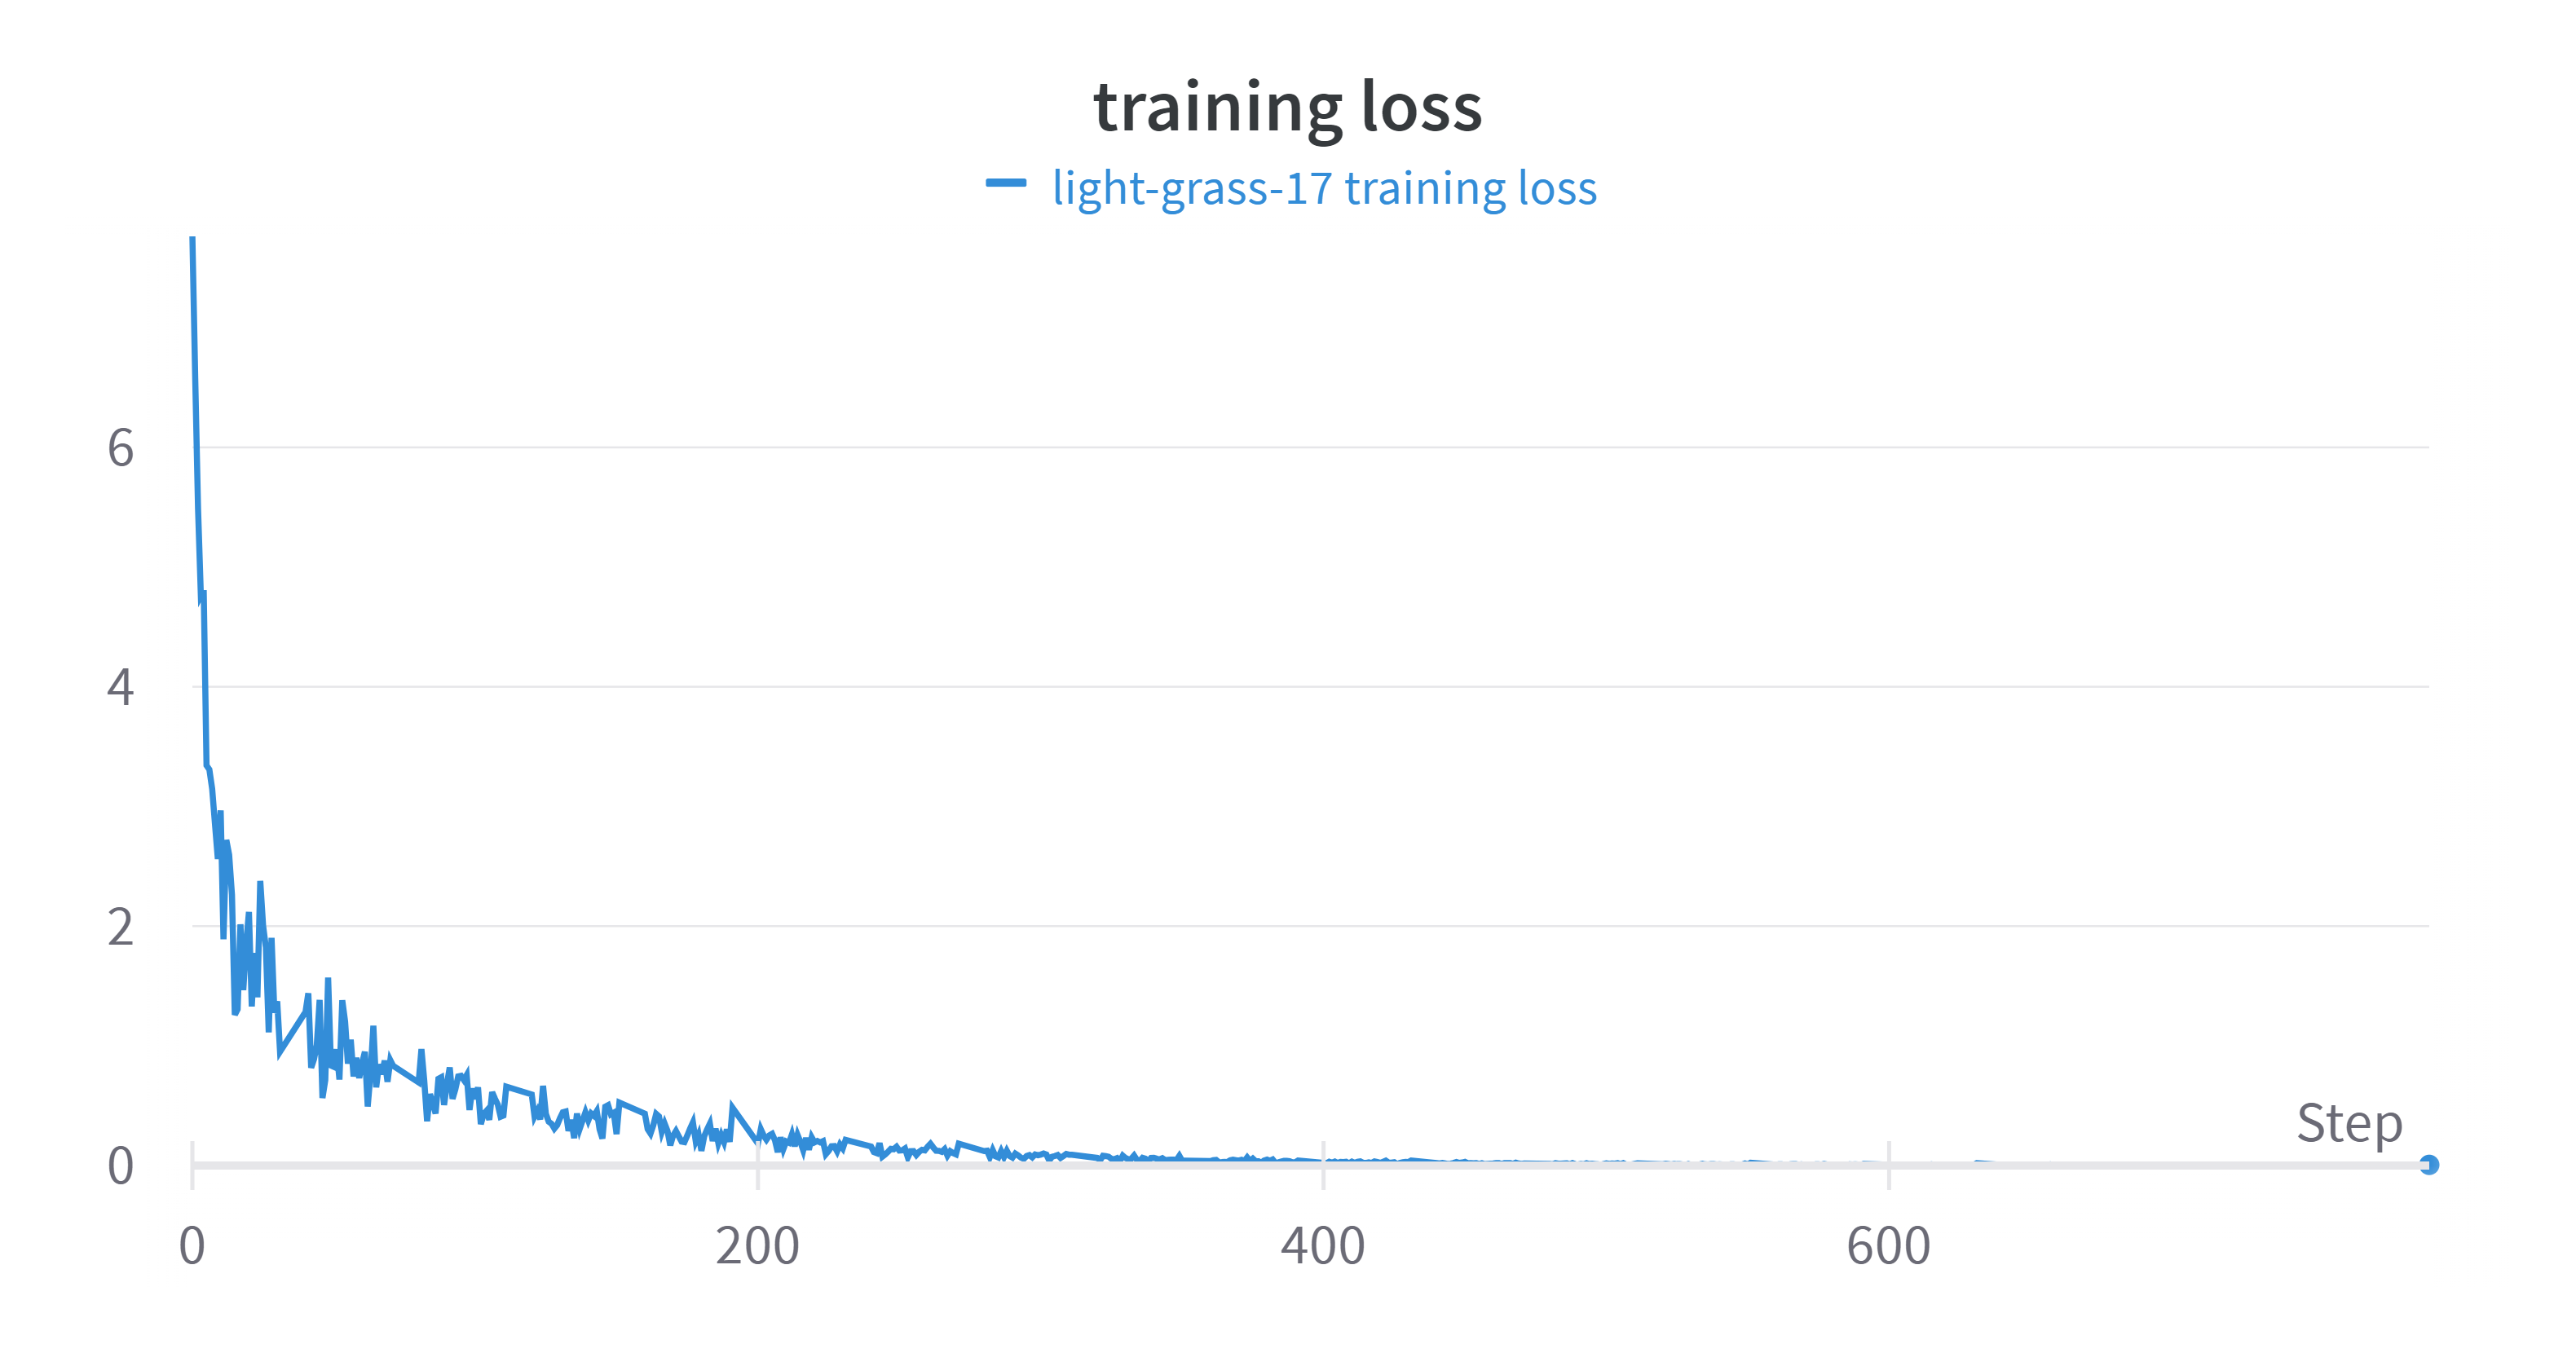

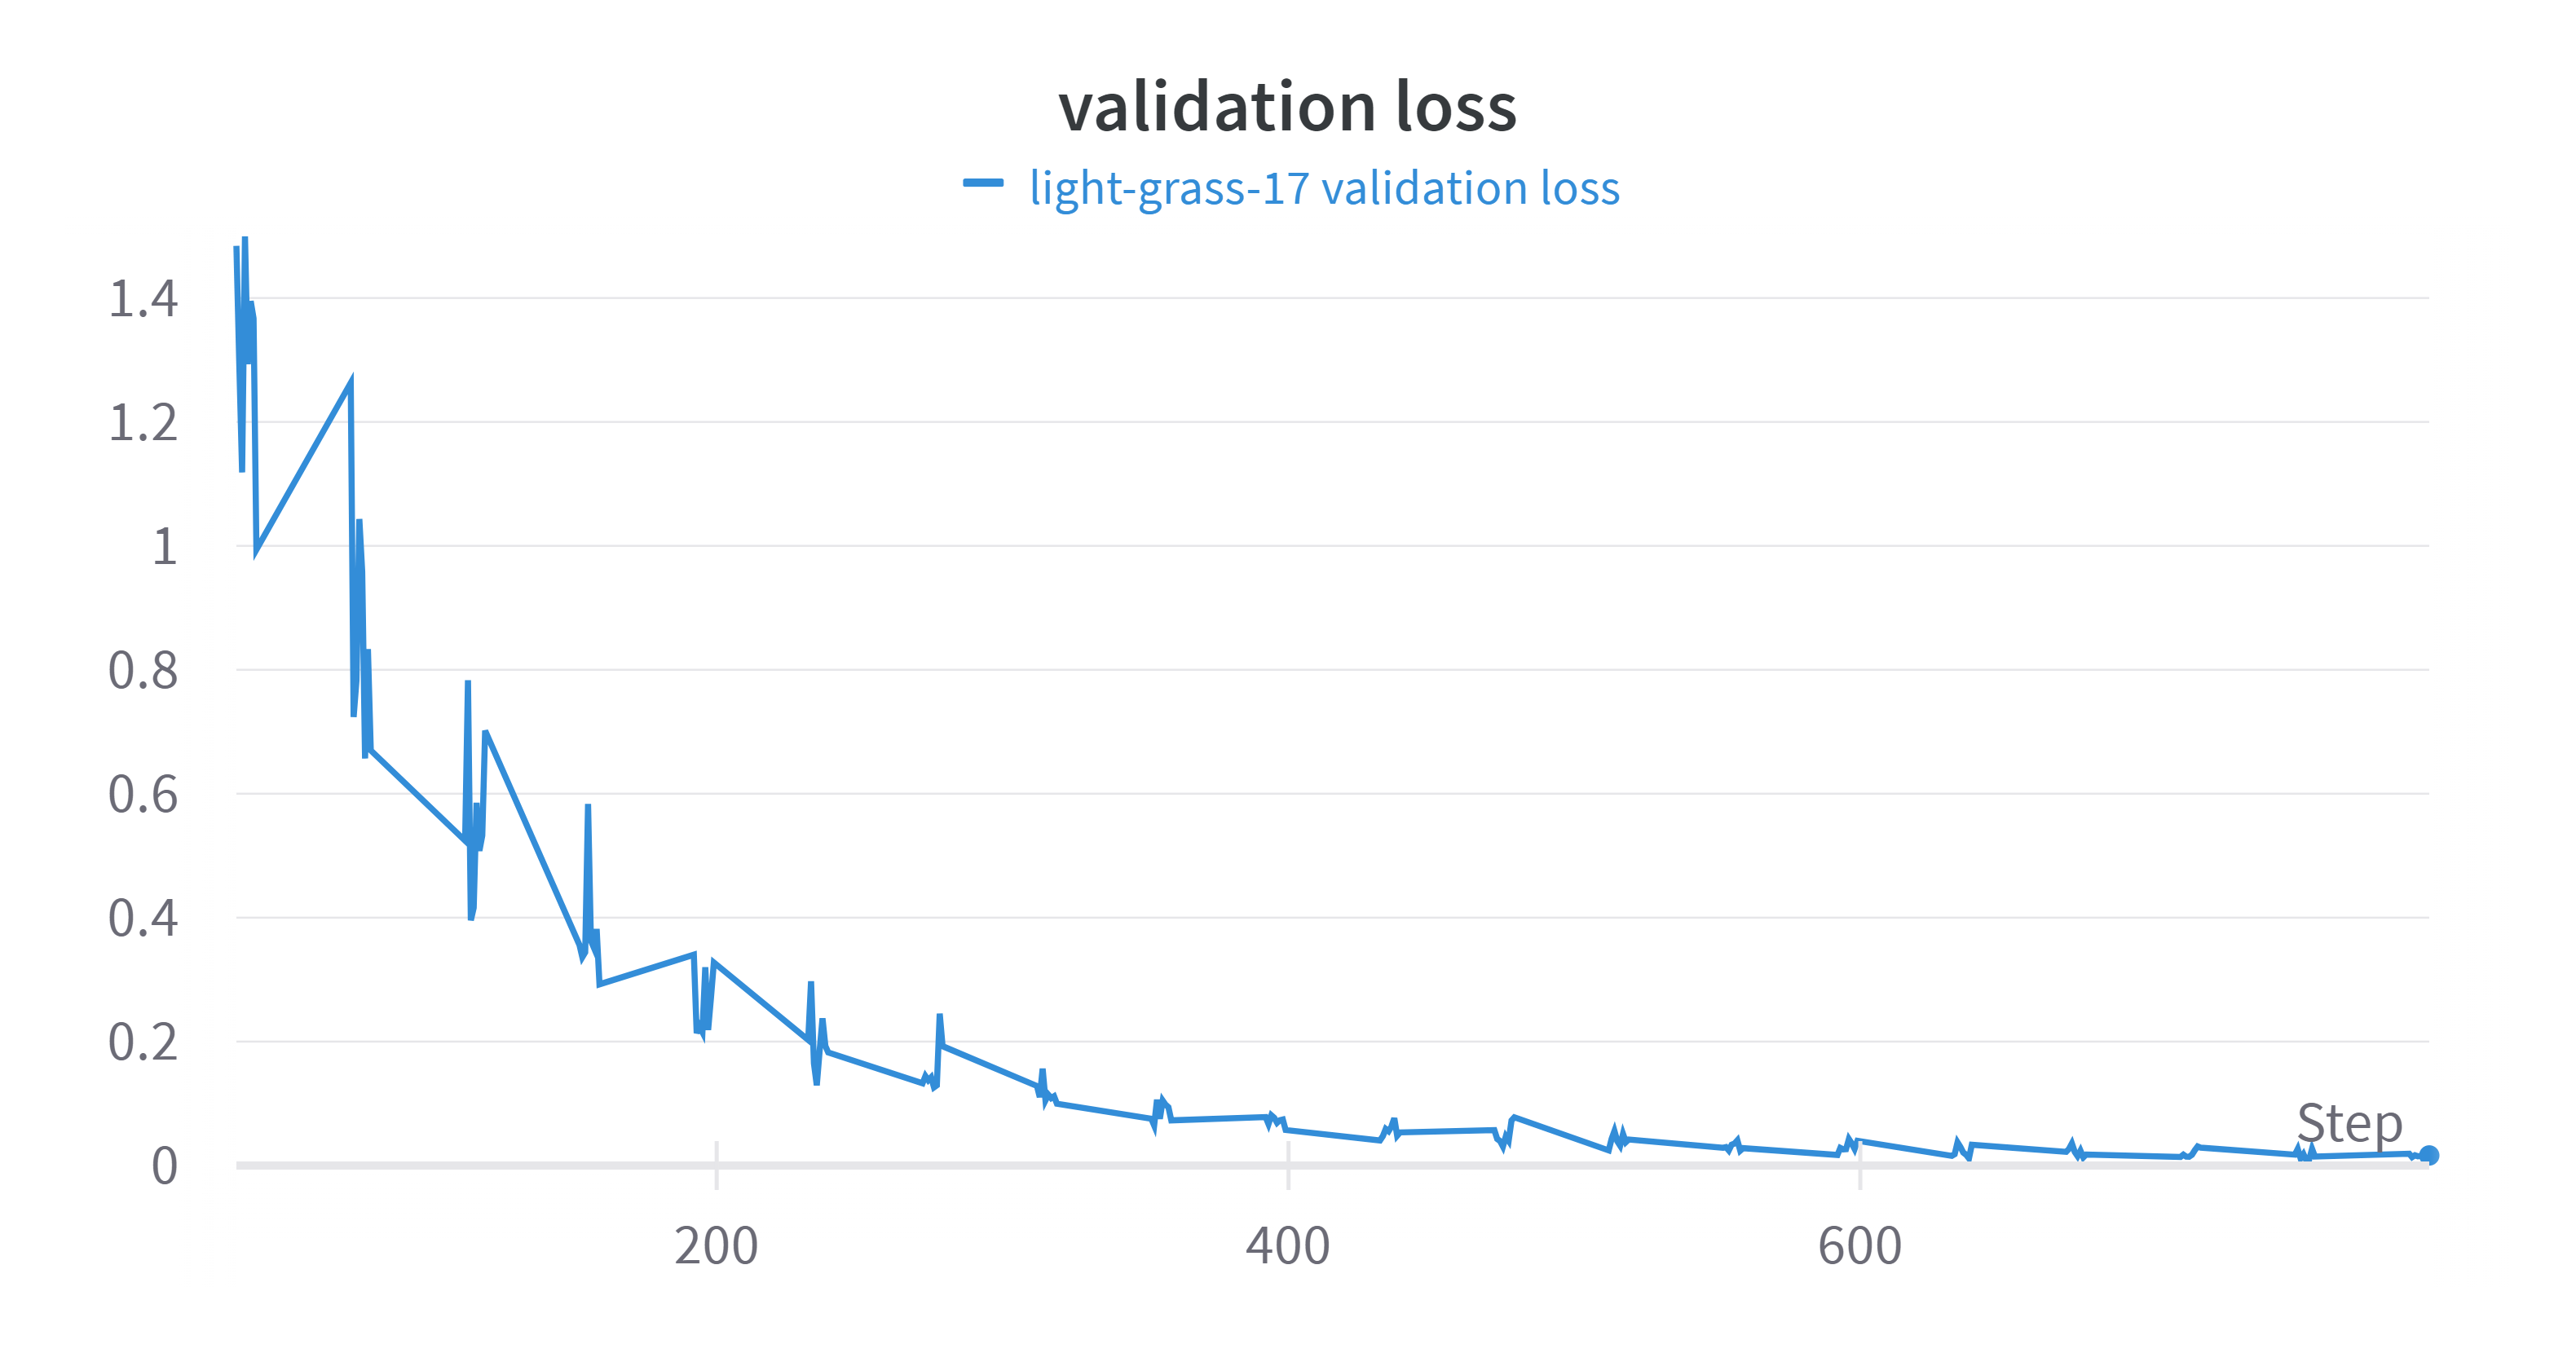

In [1]:
from IPython.display import Image, display
display(Image(filename="training_loss_duel.png"))
display(Image(filename="validation_loss_duel.png"))
